# Viewer
For looking at the results of `space-between-expt.ipynb` .

If you didn't run this notebook you can grab a copy by running `$ make pulls3-results` to grab a copy from S3 - this will put results into `energypy

## Load up all results

In [1]:
!pip install matplotlib pandas -Uq
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_parquet('./results/monthly-results.parquet')
results.head(3)

You should consider upgrading via the '/Users/adam/.pyenv/versions/3.7.9/envs/epl/bin/python3.7 -m pip install --upgrade pip' command.


,Actual Cost [$/5T],Forecast Cost [$/5T],Carbon Cost [tC/5T],objective,year,month,day,date
0,-63254.983333,-63254.983333,-1.139086,price,2014,1,1,2014-01-01
0,20312.364000,20312.364000,-627.833899,carbon,2014,1,1,2014-01-01
0,-7909.996833,-7909.996833,10.229569,price,2014,2,1,2014-02-01


## Entire time period summary

In [2]:
summary = results.groupby('objective').agg({
    'Actual Cost [$/5T]': 'sum',
    'Carbon Cost [tC/5T]': 'sum',
})
summary.loc['delta', :] = summary.loc['price', :] - summary.loc['carbon', :]
summary['carbon-price'] = summary.iloc[:, 0] / summary.iloc[:, 1]
summary.head()

,Actual Cost [$/5T],Carbon Cost [tC/5T],carbon-price
objective,,,
carbon,6.310725e+05,-65542.100676,-9.628506
price,-3.209420e+06,351.803928,-9122.751969
delta,-3.840492e+06,65893.904605,-58.282970


## 

## Monthly Summaries

In [3]:
pvt = results.pivot_table(index='date', values=['Actual Cost [$/5T]', 'Carbon Cost [tC/5T]'], columns='objective')
pvt.index = pd.to_datetime(pvt.index)
pvt.columns = [' '.join(col).strip() for col in pvt.columns.values]
pvt.head(3)

,Actual Cost [$/5T] carbon,Actual Cost [$/5T] price,Carbon Cost [tC/5T] carbon,Carbon Cost [tC/5T] price
date,,,,
2014-01-01,20312.364000,-63254.983333,-627.833899,-1.139086
2014-02-01,7335.527000,-7909.996833,-549.115497,10.229569
2014-03-01,5924.385167,-2815.955500,-588.480596,6.281464


In [4]:
pvt['price-delta'] = (pvt.loc[:, 'Actual Cost [$/5T] carbon'] - pvt.loc[:, 'Actual Cost [$/5T] price']) / 1000
pvt['carbon-delta'] = pvt.loc[:, 'Carbon Cost [tC/5T] price'] - pvt.loc[:, 'Carbon Cost [tC/5T] carbon']
pvt['carbon-price'] = 1000 * pvt['price-delta'] / pvt['carbon-delta']

reverse_cols = [c for c in pvt.columns if '/5T]' in str(c)]
pvt[reverse_cols] = pvt[reverse_cols] * -1

#pvt.index = pvt.index.strftime('%Y-%m')
pvt.head()

,Actual Cost [$/5T] carbon,Actual Cost [$/5T] price,Carbon Cost [tC/5T] carbon,Carbon Cost [tC/5T] price,price-delta,carbon-delta,carbon-price
date,,,,,,,
2014-01-01,-20312.364000,63254.983333,627.833899,1.139086,83.567347,626.694814,133.346161
2014-02-01,-7335.527000,7909.996833,549.115497,-10.229569,15.245524,559.345065,27.256026
2014-03-01,-5924.385167,2815.955500,588.480596,-6.281464,8.740341,594.762060,14.695525
2014-04-01,-5073.782833,2873.629833,655.050237,9.307700,7.947413,645.742537,12.307401
2014-05-01,-5074.773667,4118.831333,601.423888,10.021185,9.193605,591.402703,15.545423


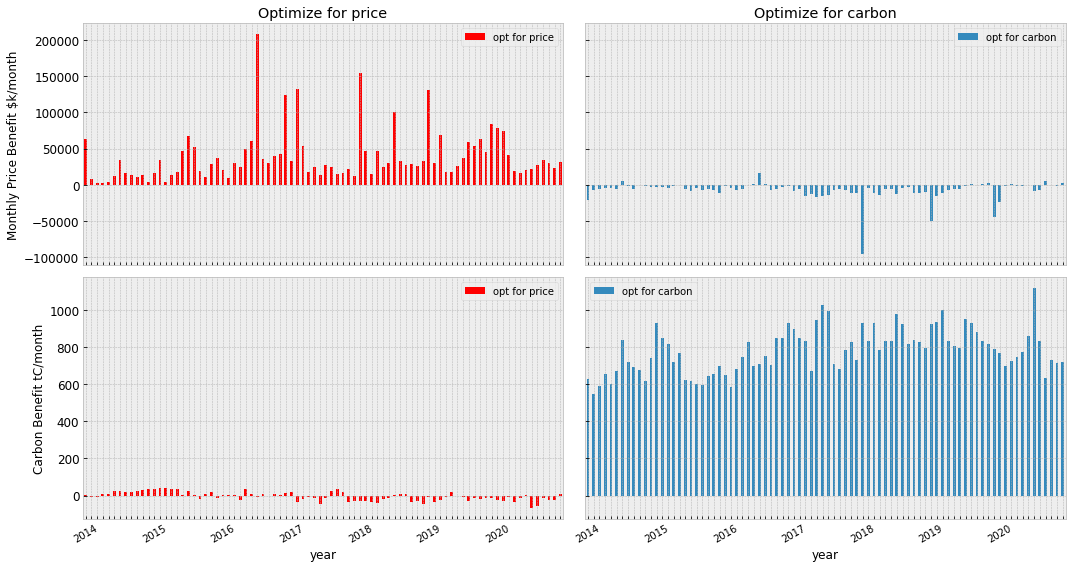

In [5]:
plt.style.use('bmh')

pvt['year-month'] = pvt.index.strftime('%Y-%m')
pvt['year'] = pvt.index.strftime('%Y')
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8), sharex=True, sharey='row')

axes[0][0].set_title('Optimize for price')
pvt.plot(ax=axes[0][0], y='Actual Cost [$/5T] price', kind='bar', x='year', label='opt for price', color='red')
pvt.plot(ax=axes[0][1], y='Actual Cost [$/5T] carbon', kind='bar', x='year', label='opt for carbon')

axes[0][1].set_title('Optimize for carbon')
pvt.plot(ax=axes[1][0], y='Carbon Cost [tC/5T] price', kind='bar', x='year', label='opt for price', color='red')
pvt.plot(ax=axes[1][1], y='Carbon Cost [tC/5T] carbon', kind='bar', x='year', label='opt for carbon')

axes[0][0].set_ylabel('Monthly Price Benefit $k/month')
axes[1][0].set_ylabel('Carbon Benefit tC/month')

for ax in axes.flatten():
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="x", labelsize=10)
    
n = 12 
for ax in[axes[1][1], axes[1][0]]:
    _ = [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
    _ = ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
f.savefig('/Users/adam/adgefficiency.github.io/assets/space-between/monthly-benefit.png')

How many days will we lose money / carbon?

Want to find

- opt for price, lose carbon
- opt for carbon, lose price

In [24]:
pvt.shape

(84, 9)

In [7]:
#  when we opt for price, how often are we negative carbon saving
100 * sum(pvt['Carbon Cost [tC/5T] price'] < 0) / pvt.shape[0]

53.57142857142857

In [8]:
#  when we opt for carbon, how often are we negative price saving
100 * sum(pvt['Actual Cost [$/5T] carbon'] < 0) / pvt.shape[0]

84.52380952380952

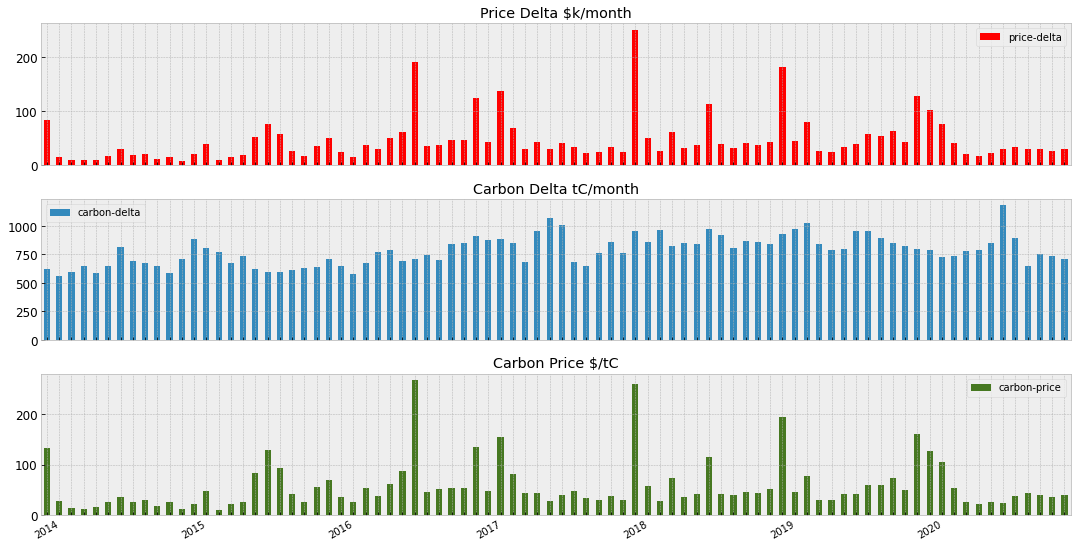

In [9]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

pvt['year-month'] = pvt.index.strftime('%Y-%m')
f, axes = plt.subplots(nrows=3, figsize=(15, 8), sharex=True)

axes[0].set_title('Price Delta $k/month')
pvt.plot(ax=axes[0], y='price-delta', kind='bar', x='year', color='red')
axes[1].set_title('Carbon Delta tC/month')
pvt.plot(ax=axes[1], y='carbon-delta', kind='bar', x='year')
axes[2].set_title('Carbon Price $/tC')
pvt.plot(ax=axes[2], y='carbon-price', kind='bar', x='year', color='#467821')
plt.tight_layout()

for ax in axes.flatten():
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="x", labelsize=10)
    
n = 12 
for ax in[axes[2]]:
    _ = [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
    _ = ax.tick_params(axis='x', rotation=30)
    ax.set_xlabel('')
    

f.savefig('/Users/adam/adgefficiency.github.io/assets/space-between/monthly.png')

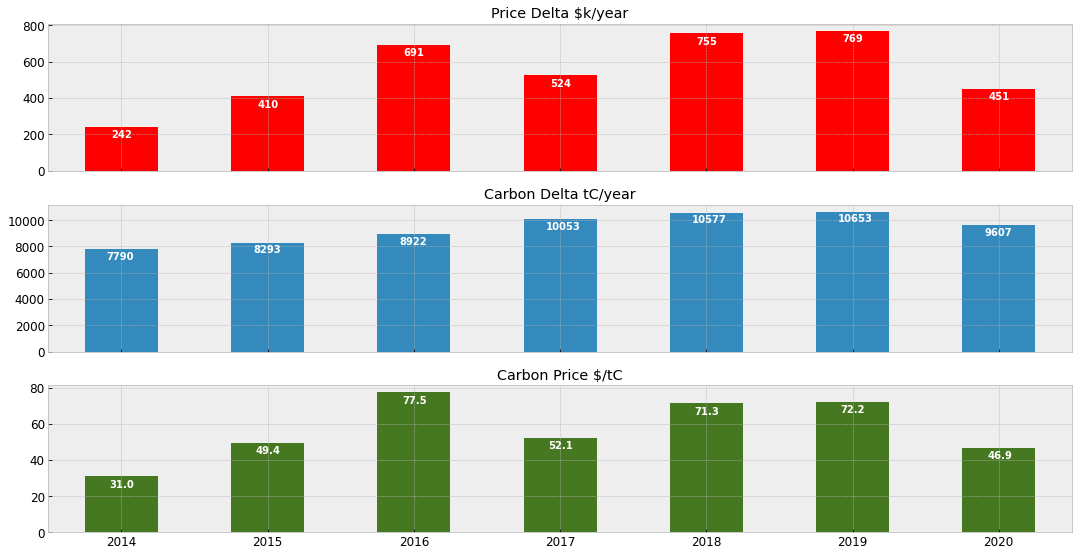

In [10]:
#  TODO - put labels on the bars
annual = pvt.groupby(pvt.index.year).agg({
    'price-delta': 'sum',
    'carbon-delta': 'sum'
})
annual['carbon-price'] = 1000 * annual['price-delta'] / annual['carbon-delta']

f, axes = plt.subplots(nrows=3, figsize=(15, 8), sharex=True)

axes[0].set_title('Price Delta $k/year')
for i, v in enumerate(annual['price-delta']):
    axes[0].text(i-0.07, v-60, f"{v:.0f}", fontweight='bold', color='white')
annual.plot(ax=axes[0], y='price-delta', kind='bar', color='red')

axes[1].set_title('Carbon Delta tC/year')
for i, v in enumerate(annual['carbon-delta']):
    axes[1].text(i-0.1, v-800, f"{v:.0f}", fontweight='bold', color='white')
    
annual.plot(ax=axes[1], y='carbon-delta', kind='bar')

axes[2].set_title('Carbon Price $/tC')
annual.plot(ax=axes[2], y='carbon-price', kind='bar', color='#467821')
for i, v in enumerate(annual['carbon-price']):
    axes[2].text(i-0.08, v-6, f"{v:.1f}", fontweight='bold', color='white')
    
axes[2].set_xlabel('')
plt.tight_layout()

for ax in axes:
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.get_legend().remove()
    
    _ = ax.tick_params(axis='x', rotation=0)

f.savefig('/Users/adam/adgefficiency.github.io/assets/space-between/annual.png')

In [11]:
ds.head(3)

NameError: name 'ds' is not defined

In [ ]:
ds = pd.read_parquet('./results/price-carbon-signals.parquet')
ds = ds.groupby([ds.index.year, ds.index.month]).mean()

ds.index = ds.index.set_names(['year', 'month'])
ds = ds.reset_index()

#  scatter carbon delta versus price delta
f, axes = plt.subplots(figsize=(20,10), ncols=2, sharey=True)
pvt.plot(y='price-delta', x='carbon-delta', kind='scatter', ax=axes[0], c='#348ABD', linewidths=4)
axes[0].set_ylabel('Price Delta $k/month')
axes[0].set_xlabel('Carbon Delta tC/month')

ds.plot(y='RRP', x='Increase', kind='scatter', ax=axes[1], color='#348ABD', linewidths=4,)
axes[1].set_ylabel('Average Monthly Price $/MWh')
axes[1].set_xlabel('Average Carbon Intensity tC/MWh')
axes[1].legend()

for ax in axes:
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

f.savefig('/Users/adam/adgefficiency.github.io/assets/space-between/scatter.png')